In [1]:
import glob

import torch

import numpy as np
import pylab as plt
import pandas as pd

from copy import deepcopy
from utils.models import LeNet5, LeNet5Dropout

In [2]:
from utils.xedl import xEDLWrapper
from utils.edl import EDLWrapper
from utils.dropout import DropoutWrapper
from utils.prior_network import PriorNetWrapper

from utils.datasets import load_mnist_notmnist, load_svhn_cifar10, load_cifar5

path = './results/state_dicts/'

In [3]:
def get_results(dataset, device='cpu'):
    if dataset =='mnist':
        n_channel = 1
        n_classes = 10
        _, _, _, test_ds_in, test_ds_out = load_mnist_notmnist()
    elif dataset =='svhn':
        n_channel = 3
        n_classes = 10
        _, _, _, test_ds_in, test_ds_out = load_svhn_cifar10()
    elif dataset =='cifar5':
        n_channel = 3
        n_classes = 5
        _, _, _, test_ds_in, test_ds_out = load_cifar5()
    test_loader_in, test_loader_out = torch.utils.data.DataLoader(test_ds_in, 1024), torch.utils.data.DataLoader(test_ds_out, 1024)
    
    net_init = LeNet5(n_channel, n_classes)


    for p in glob.glob(path + '*'):
        if dataset in p:
            state_dict = torch.load(p, map_location=device)
            if 'xedl' in p:
                net_xedl = xEDLWrapper(deepcopy(net_init), lmb=None, ood_generator=None)
                net_xedl.load_state_dict(state_dict)
            elif 'priornet' in p:
                net_priornet = PriorNetWrapper(deepcopy(net_init), gamma=None, ood_generator=None)
                net_priornet.load_state_dict(state_dict)
            elif 'edl' in p:
                net_edl = EDLWrapper(deepcopy(net_init))
                net_edl.load_state_dict(state_dict)
            elif 'dropout' in p:
                net_dropout = DropoutWrapper(LeNet5Dropout(n_channel, n_classes))
                net_dropout.load_state_dict(state_dict)
                

    results_xedl = net_xedl.score(test_loader_in, test_loader_out)
    results_edl = net_edl.score(test_loader_in, test_loader_out)
    results_dropout = net_dropout.score(test_loader_in, test_loader_out)
    results_priornet = net_priornet.score(test_loader_in, test_loader_out)
    # TODO add others
    
    return (
        ('AE-DNN', results_xedl), 
        ('EDL', results_edl),
        ('Dropout', results_dropout),
        ('PriorNet', results_priornet)
    )

In [4]:
results_mnist = get_results('mnist')
results_svhn = get_results('svhn')
results_cifar5 = get_results('cifar5')

Using downloaded and verified file: /home/denis/.datasets/notMNIST/notMNIST_small.tar.gz
Using downloaded and verified file: /home/denis/.datasets/train_32x32.mat
Using downloaded and verified file: /home/denis/.datasets/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Metrics

In [5]:
metrics = {'accuracy', 'ece', 'nll', 'brier_score', 'auroc'}
method_names = []
results = []
for m_name, r in results_mnist:
    r = {key:item for key, item in r.items() if key in metrics}
    results.append(r)
    method_names.append(m_name)
pd.DataFrame(results, index=method_names)

,accuracy,ece,nll,brier_score,auroc
AE-DNN,0.9875,0.004750,0.042100,0.002023,0.997991
EDL,0.9891,0.021719,0.066698,0.002469,0.962225
Dropout,0.9901,0.014417,0.039315,0.001601,0.971464
PriorNet,0.9895,0.102778,0.144066,0.003685,0.997246


In [6]:
metrics = {'accuracy', 'ece', 'nll', 'brier_score', 'auroc'}
method_names = []
results = []
for m_name, r in results_svhn:
    r = {key:item for key, item in r.items() if key in metrics}
    results.append(r)
    method_names.append(m_name)
pd.DataFrame(results, index=method_names)

,accuracy,ece,nll,brier_score,auroc
AE-DNN,0.849147,0.020429,0.513672,0.022036,0.968926
EDL,0.195874,0.091469,2.295137,0.089849,0.603077
Dropout,0.883912,0.129040,0.471626,0.019677,0.917767
PriorNet,0.869699,0.101879,0.504809,0.020554,0.908253


In [7]:
metrics = {'accuracy', 'ece', 'nll', 'brier_score', 'auroc'}
method_names = []
results = []
for m_name, r in results_cifar5:
    r = {key:item for key, item in r.items() if key in metrics}
    results.append(r)
    method_names.append(m_name)
pd.DataFrame(results, index=method_names)

,accuracy,ece,nll,brier_score,auroc
AE-DNN,0.7952,0.036636,0.562487,0.058635,0.655576
EDL,0.7470,0.182044,0.908860,0.087102,0.621887
Dropout,0.7648,0.143079,0.699221,0.071147,0.622143
PriorNet,0.7882,0.014026,0.584746,0.060374,0.667607


# Uncertainty Histograms

In [8]:
def plot_uc(all_results, loc=2):
    linewidth = 2.5
    plt.figure(figsize=(5, 5))
    n_bins = 30
    bins = np.linspace(0, 1, n_bins)
    
    for method_name, results in all_results:
        # normalize between 0 and 1
        unc_in = results['unc_in']
        unc_out = results['unc_out']
        
        tmp = torch.cat((unc_in, unc_out))
        unc_min, unc_max  = tmp.min(), tmp.max()
        # unc_in = (unc_in - unc_min) / (unc_max - unc_min)
        unc_out = (unc_out - unc_min) / (unc_max - unc_min)

        # plt.hist( unc_in, bins=bins, histtype='step', linewidth=linewidth)
        plt.hist(unc_out, bins=bins, histtype='step', linewidth=linewidth, label=method_name)
    plt.legend(loc=loc)
    plt.xlabel('Normalized Uncertainty')
    plt.ylabel('Frequency')
    plt.tight_layout()

In [9]:
print(results_mnist[0][-1]['unc_in'].mean(), results_mnist[0][-1]['unc_out'].mean())
print(results_svhn[0][-1]['unc_in'].mean(), results_svhn[0][-1]['unc_out'].mean())
print(results_cifar5[0][-1]['unc_in'].mean(), results_cifar5[0][-1]['unc_out'].mean())

tensor(0.0077) tensor(0.9477)
tensor(0.0479) tensor(0.6932)
tensor(0.0082) tensor(0.0180)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


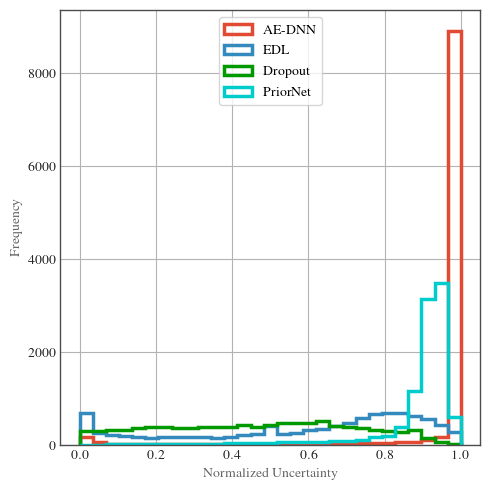

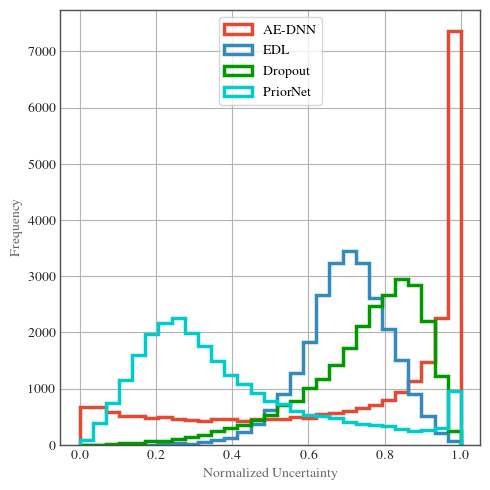

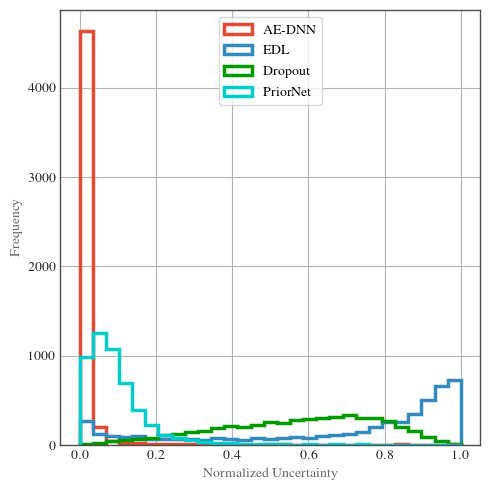

In [10]:
plot_uc(results_mnist, loc=9)
plt.show()

plot_uc(results_svhn, loc=9)
plt.show()

plot_uc(results_cifar5, loc=9)
plt.show()

In [11]:
def plot_uc_results(results, title='', normalize=True, logarithmic=False):
    linewidth = 3
    bins = 30
    fig = plt.figure(figsize=(10, 8))
    for i, (name, tmp) in enumerate(results):
        unc_in, unc_out = tmp['unc_in'], tmp['unc_out']
        
        if normalize:
            t = torch.cat((unc_in, unc_out))
            unc_min, unc_max  = t.min(), t.max()
            # unc_in = (unc_in - unc_min) / (unc_max - unc_min)
            unc_in = (unc_in - unc_min) / (unc_max - unc_min)
            unc_out = (unc_out - unc_min) / (unc_max - unc_min)
            
            if logarithmic:
                unc_in = unc_in.clamp(1e-8, 1-1e-8).log()
                unc_out = unc_out.clamp(1e-8, 1-1e-8).log()
                
        plt.subplot(221 + i)
        plt.title(name)
        plt.hist(unc_in,  bins=bins, histtype='step', linewidth=linewidth, label='ID')
        plt.hist(unc_out, bins=bins, histtype='step', linewidth=linewidth, label='OOD')
        plt.legend(loc=9)
    plt.tight_layout()
    if logarithmic:
        title += ' -- Logarithmic Space'
    fig.suptitle(title, y=1.03)
   

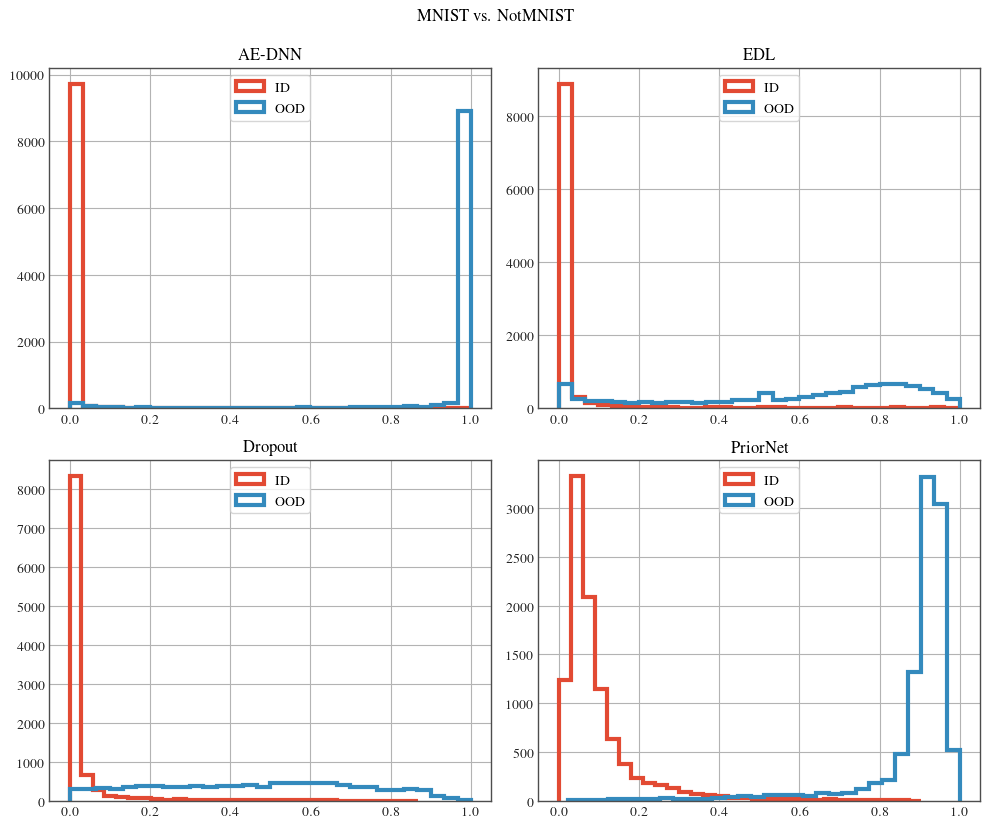

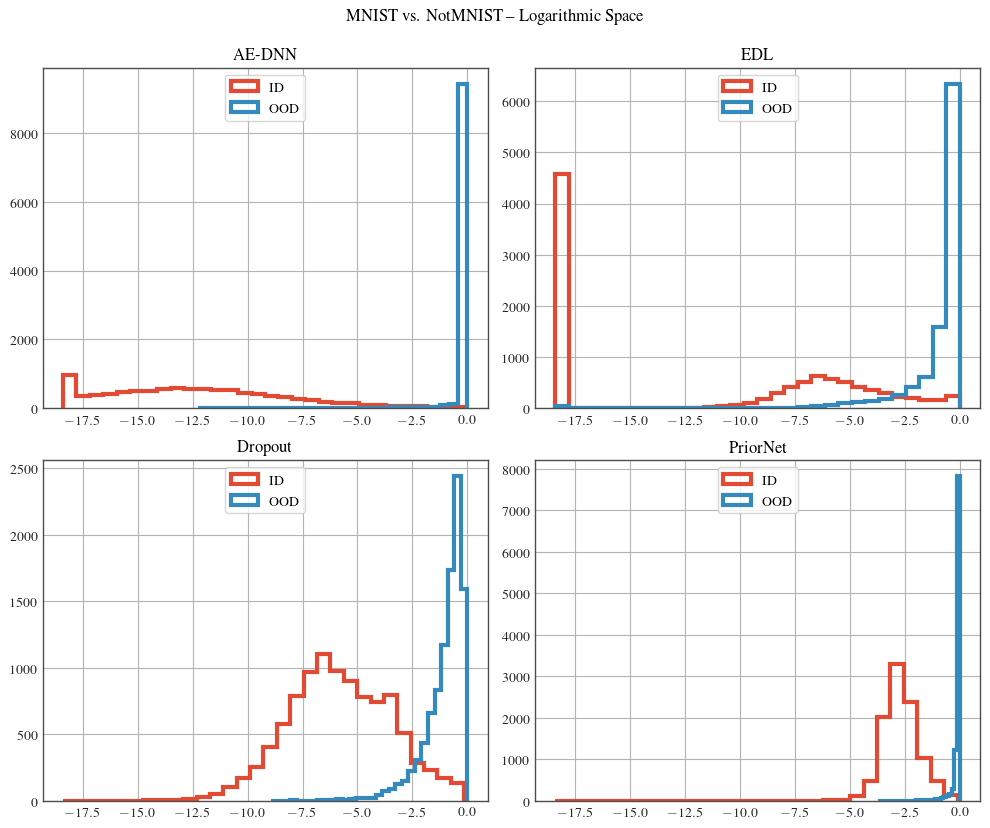

In [12]:
plot_uc_results(results_mnist, 'MNIST vs. NotMNIST')
plt.savefig('plots/UC_mnist.png')
plt.show()

plot_uc_results(results_mnist, 'MNIST vs. NotMNIST', logarithmic=True)
plt.savefig('plots/UC_mnist_log.png')
plt.show()

In [13]:
pngplot_uc_results(results_svhn, 'SVHN vs. CIFAR10')
plt.savefig('plots/UC_svhn.png')
plot_uc_results(results_svhn, 'SVHN vs. CIFAR10', logarithmic=True)
plt.savefig('plots/UC_svhn_log.png')
plt.show()

NameError: name 'pngplot_uc_results' is not defined

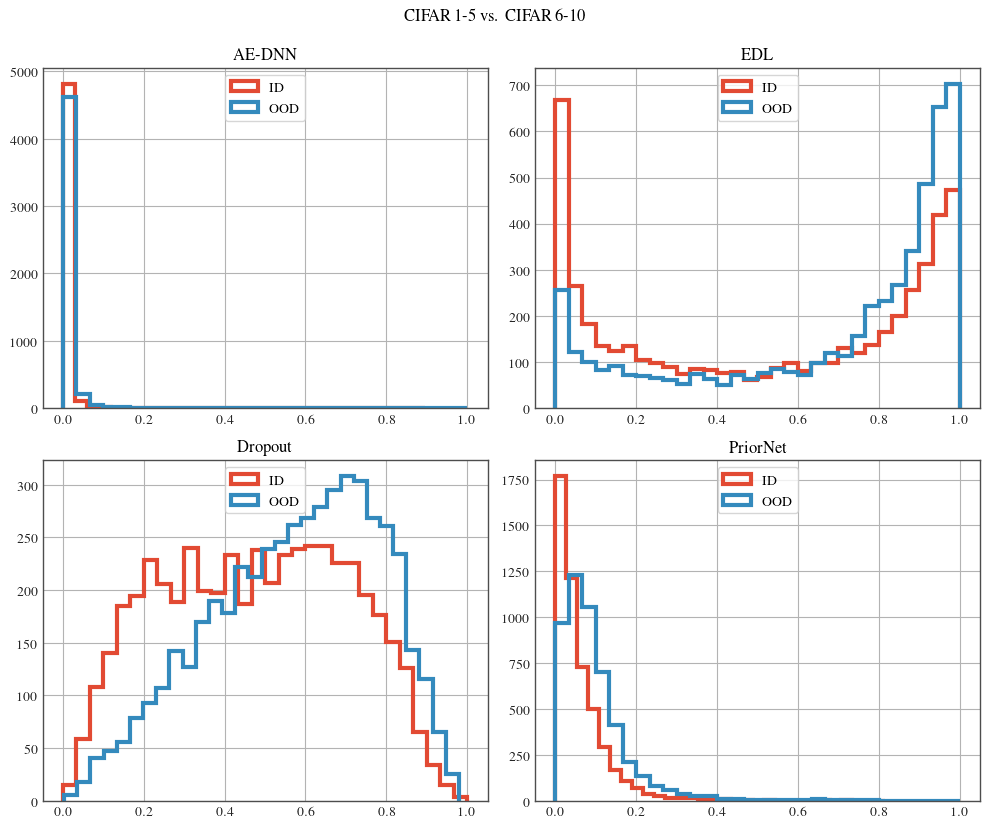

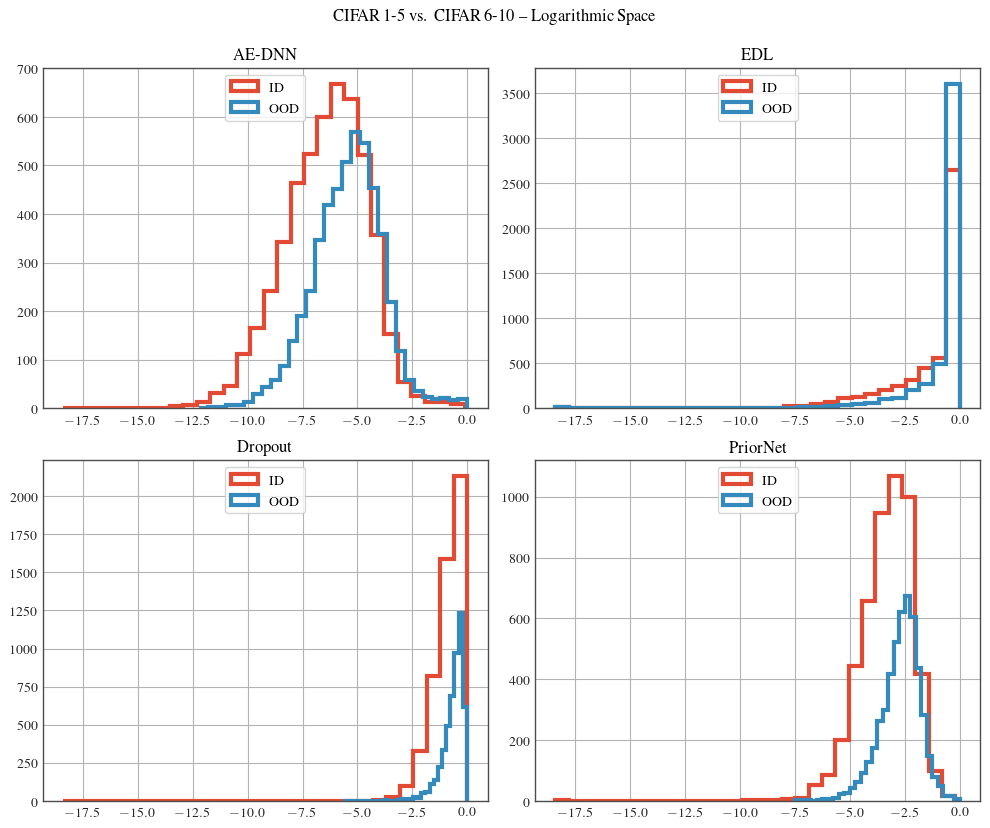

In [27]:
plot_uc_results(results_cifar5, 'CIFAR\,1-5 vs. CIFAR\,6-10')
plt.savefig('plots/UC_cifar5.pdf')
plt.show()

plot_uc_results(results_cifar5, 'CIFAR\,1-5 vs. CIFAR\,6-10', logarithmic=True)
plt.savefig('plots/UC_cifar5_log.pdf')
plt.show()